In [39]:
import requests


def get_tle(norad_cat_id):
    # Space-Track API의 URL
    url = "https://www.space-track.org/ajaxauth/login"

    # 요청에 필요한 인증 정보
    payload = {"identity": '', "password": ''}

    # Session 객체 생성
    session = requests.Session()

    # 로그인 요청
    response = session.post(url, data=payload)

    if response.status_code != 200:
        print("로그인에 실패했습니다.")
        return None

    # TLE 요청
    response = session.get(
        f"https://www.space-track.org/basicspacedata/query/class/gp/NORAD_CAT_ID/{norad_cat_id}/format/tle/emptyresult/show"
    )
    response_text_split = response.text.split('\r\n')
    first_line = response_text_split[0]
    second_line = response_text_split[1]
    return first_line, second_line

def get_tles(username, password, norad_cat_ids):
    tles = dict()
    for norad_cat_id in norad_cat_ids:
        first_line, second_line = get_tle(username, password, norad_cat_id)
        tles[norad_cat_id] = (first_line, second_line)
    return tles
        


# TLE을 가져올 NORAD Catalog ID
norad_cat_id = "58932"  # 국제 우주 정거장 (ISS)의 NORAD Catalog ID

# TLE 가져오기
first_line, second_line = get_tle(norad_cat_id)
print(first_line, "\n",second_line)

# TLE 출력
from sgp4.api import Satrec
# 1. TLE을 Satrec 객체로 변환
satellite = Satrec.twoline2rv(first_line, second_line)

# 2. 위도, 경도, 고도를 이용해 위성의 위치를 계산
# https://pypi.org/project/sgp4/
mean_motion = satellite.no_kozai # 평균 움직임, radians per minute
mean_motion_in_degrees = mean_motion * 180 / 3.141592653589793
print(mean_motion)
print(mean_motion_in_degrees)
period_of_satellite = 360 / mean_motion_in_degrees # 분 단위로 변환
print(period_of_satellite)
period_of_satellite_in_seconds = period_of_satellite * 60
print(period_of_satellite_in_seconds)

1 58932U 24027B   24168.90484136  .00015512  00000-0  57096-3 0  9992 
 2 58932  53.1599 359.4684 0001250  99.3183 260.7958 15.28052704 20756
0.06667387707200582
3.8201317600000007
94.23758723966105
5654.255234379663


In [40]:
from sgp4.api import days2mdhms, jday
import datetime

# 3. Get epoch time
month, day, hour, minute, second = days2mdhms(satellite.epochyr, satellite.epochdays)

epoch_datetime = datetime.datetime(2024, month, day, hour, minute, int(second))

positions = []
velocities = []
for second in range(0, int(period_of_satellite_in_seconds), 60):
    time = epoch_datetime + datetime.timedelta(seconds=second)
    # 4. Julian Date 변환 (Date -> Julian Date)
    jd, fr = jday(time.year, time.month, time.day, time.hour, time.minute, time.second)
    # 5. 위성의 위치 계산
    error_code, position, velocity = satellite.sgp4(jd, fr)
    
    positions.append(position)
    velocities.append(velocity)
    print(time, position, velocity)
    norm_position = (position[0]**2 + position[1]**2 + position[2]**2)**0.5
    # print(f"altitude: {norm_position}")
    


2024-06-16 21:42:58 (6860.501236636979, -64.99727328932352, -1.793182794295329) (0.03730020558281484, 4.569746723854824, 6.104084550458308)
2024-06-16 21:43:58 (6847.478723878835, 209.128529350538, 364.1830190418523) (-0.471231309167401, 4.564399592332974, 6.090602735106762)
2024-06-16 21:44:58 (6803.993303096446, 482.3239832478468, 728.5344656841544) (-0.977751315619617, 4.538744016398112, 6.049944810146118)
2024-06-16 21:45:58 (6730.233849316594, 753.3733818185266, 1089.6352092263915) (-1.4799889488200324, 4.492888841131105, 5.982285288042403)
2024-06-16 21:46:58 (6626.524984617352, 1021.070307668841, 1445.8734711340612) (-1.9756920112381278, 4.427034790628664, 5.887921841567912)
2024-06-16 21:47:58 (6493.325636235111, 1284.2231195492939, 1795.6589927381858) (-2.462637696619591, 4.341473515110413, 5.767273887574453)
2024-06-16 21:48:58 (6331.226956200831, 1541.6603676328502, 2137.430281409012) (-2.938643133096038, 4.236586154736164, 5.6208805229080125)
2024-06-16 21:49:58 (6140.94961

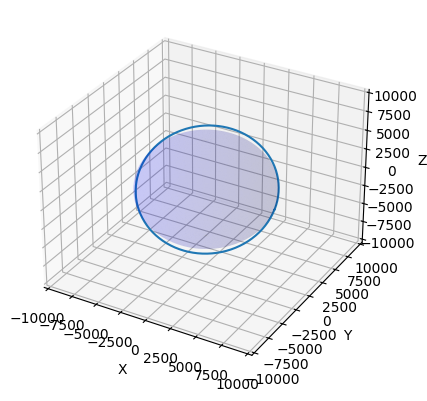

In [41]:
#draw orbit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-10000, 10000)
ax.set_ylim(-10000, 10000)
ax.set_zlim(-10000, 10000)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('auto')
ax.grid(True)
positions = np.array(positions)

#draw earth sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 6378 * np.outer(np.cos(u), np.sin(v))
y = 6378 * np.outer(np.sin(u), np.sin(v))
z = 6378 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])
plt.show()
